# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import tensorflow as tf

In [2]:
#Here I will keep all modules import. It helps don't forget to import something

import os
import sys
import cv2
import time
import pickle
import random
import warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from sklearn.utils import shuffle
from skimage import exposure
from sklearn.model_selection import train_test_split
from skimage import io

In [3]:
training_file = "train.p"
testing_file = "test.p"
sign_file = pd.read_csv("signnames.csv")
sign_names = sign_file.values[:, 1]

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
sign_cls, cls_ind, cls_count = np.unique(y_train, return_index = True, return_counts = True)
n_classes = cls_count.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

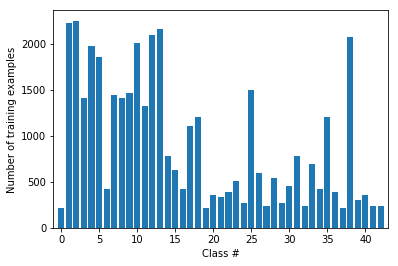

In [5]:
# check how much img in each class
plt.bar( np.arange(n_classes), cls_count, align='center' )
plt.xlabel('Class #')
plt.ylabel('Number of training examples')
plt.xlim([-1, n_classes])
plt.show()

Hm, it looks like that the number of images in each class are different. I guess it can be the reason why some of img's will be predicted better. One way to fix this issue is to add images using augmentation of present images. But the best idea is just go to street and find more signs. 

In [6]:
# let's see it in the table format

data = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
sorted_data = sorted(data, key=lambda x: x[1])
sign_file['Occurance'] = pd.Series(np.asarray(sorted_data).T[1], index=np.asarray(sorted_data).T[0])
sorted_data = sign_file.sort_values(['Occurance'],ascending=[0]).reset_index()
sorted_data = sorted_data.drop('index', 1)
print(sorted_data)

    ClassId                                           SignName  Occurance
0         2                               Speed limit (50km/h)       2250
1         1                               Speed limit (30km/h)       2220
2        13                                              Yield       2160
3        12                                      Priority road       2100
4        38                                         Keep right       2070
5        10       No passing for vehicles over 3.5 metric tons       2010
6         4                               Speed limit (70km/h)       1980
7         5                               Speed limit (80km/h)       1860
8        25                                          Road work       1500
9         9                                         No passing       1470
10        7                              Speed limit (100km/h)       1440
11        3                               Speed limit (60km/h)       1410
12        8                           

### Sample images
Let's check out the sign samples - plot 5 random images for each class.

Class: 'Speed limit (20km/h)' has 210 samples


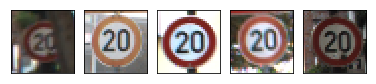

Class: 'Speed limit (30km/h)' has 2220 samples


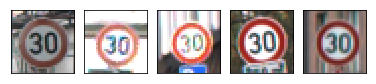

Class: 'Speed limit (50km/h)' has 2250 samples


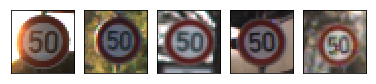

Class: 'Speed limit (60km/h)' has 1410 samples


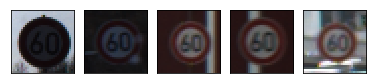

Class: 'Speed limit (70km/h)' has 1980 samples


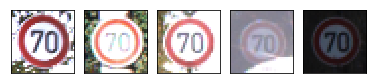

Class: 'Speed limit (80km/h)' has 1860 samples


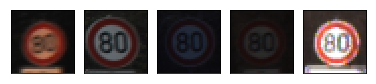

Class: 'End of speed limit (80km/h)' has 420 samples


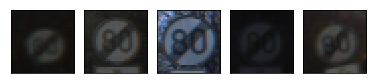

Class: 'Speed limit (100km/h)' has 1440 samples


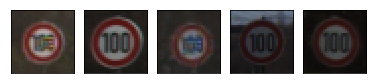

Class: 'Speed limit (120km/h)' has 1410 samples


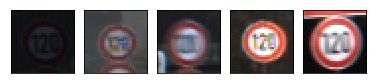

Class: 'No passing' has 1470 samples


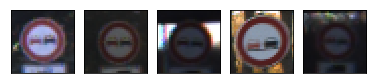

Class: 'No passing for vehicles over 3.5 metric tons' has 2010 samples


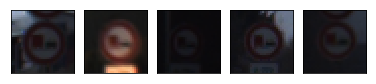

Class: 'Right-of-way at the next intersection' has 1320 samples


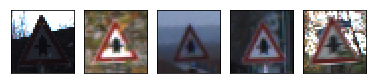

Class: 'Priority road' has 2100 samples


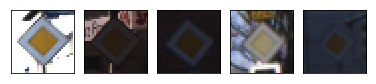

Class: 'Yield' has 2160 samples


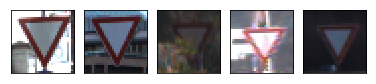

Class: 'Stop' has 780 samples


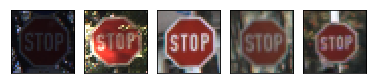

Class: 'No vehicles' has 630 samples


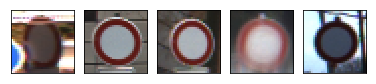

Class: 'Vehicles over 3.5 metric tons prohibited' has 420 samples


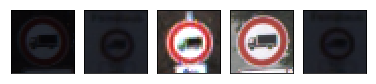

Class: 'No entry' has 1110 samples


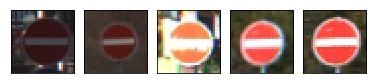

Class: 'General caution' has 1200 samples


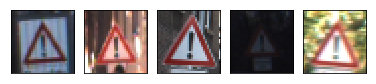

Class: 'Dangerous curve to the left' has 210 samples


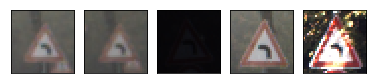

Class: 'Dangerous curve to the right' has 360 samples


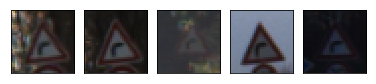

Class: 'Double curve' has 330 samples


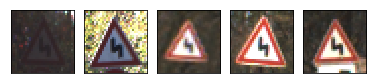

Class: 'Bumpy road' has 390 samples


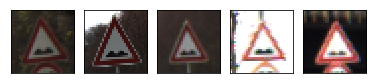

Class: 'Slippery road' has 510 samples


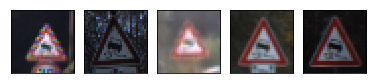

Class: 'Road narrows on the right' has 270 samples


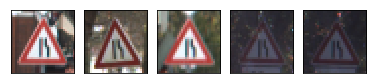

Class: 'Road work' has 1500 samples


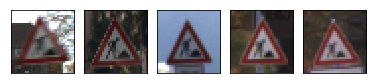

Class: 'Traffic signals' has 600 samples


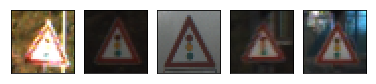

Class: 'Pedestrians' has 240 samples


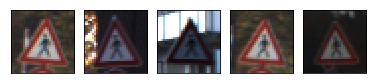

Class: 'Children crossing' has 540 samples


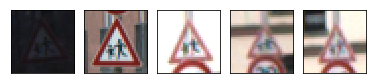

Class: 'Bicycles crossing' has 270 samples


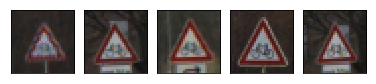

Class: 'Beware of ice/snow' has 450 samples


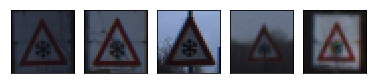

Class: 'Wild animals crossing' has 780 samples


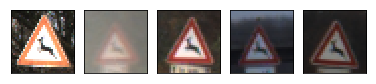

Class: 'End of all speed and passing limits' has 240 samples


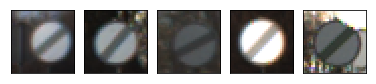

Class: 'Turn right ahead' has 689 samples


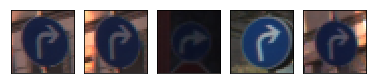

Class: 'Turn left ahead' has 420 samples


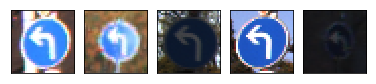

Class: 'Ahead only' has 1200 samples


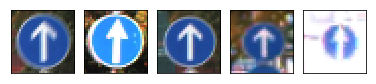

Class: 'Go straight or right' has 390 samples


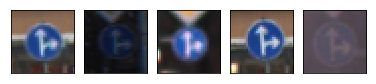

Class: 'Go straight or left' has 210 samples


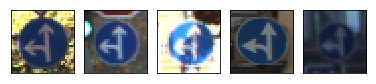

Class: 'Keep right' has 2070 samples


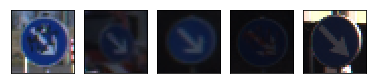

Class: 'Keep left' has 300 samples


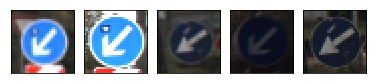

Class: 'Roundabout mandatory' has 360 samples


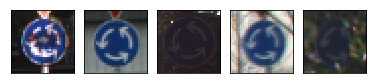

Class: 'End of no passing' has 240 samples


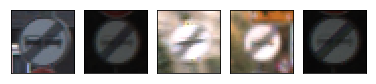

Class: 'End of no passing by vehicles over 3.5 metric tons' has 240 samples


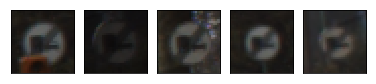

In [7]:
# Let's see some samples from some classes 
index = [random.randint(0, len(X_train)) for x in range(25) ]

def plot_images(images, labels, gray=False):
    classes, indices, counts = np.unique(y_train, return_index = True, return_counts = True)
    
    for cls, ndx, cnt in zip(classes, indices, counts):
        r_ndx = random.sample(range(ndx, ndx + cnt), 5)
        fig = plt.figure(figsize = (10, 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)
        print("Class: '%s' has %s samples" % (sign_names[cls], str(cnt)))
        for i in range(5):
            axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
            if gray:
                axis.imshow(X_train[r_ndx[i]],cmap='gray')
            else:
                axis.imshow(X_train[r_ndx[i]])
        plt.show() 

# Plot the images and labels using our helper-function above.
plot_images(X_train, y_train,index)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
# It's good idea to see that your PC is really busy
def print_progress(iteration, total):
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)
    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [9]:
# First step - I want to grayscale and equalize images
def grayscaling(X, y, test=False):
    X_extended = []
    y_extended = []
    
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            img_gray = cv2.cvtColor(X[i], cv2.COLOR_BGR2GRAY)
            img_gray = (img_gray / 255.).astype(np.float32)
            img_gray = exposure.equalize_adapthist(img_gray)
            X_extended.append(img_gray)
            y_extended.append(y[i])
        print_progress(i, X.shape[0]-1)
        
    X_extended = np.array(X_extended,dtype = np.float32())
    y_extended = np.array(y_extended,dtype = np.int64())
   
    # shuffle
    #if test:
        #y_extended = np.eye(43)[y_extended]
        #X_extended, y_extended = shuffle(X_extended, y_extended)

    # Add a single grayscale channel
    X_extended = X_extended.reshape(X_extended.shape + (1,))
    return X_extended,y_extended

In [10]:
# Second step - flip all images that can be flipped (this idea is from Slack discussion)
def flip_flop(X, y):
    cross = np.array([[19, 20],[33, 34],[36, 37],[38, 39],[20, 19],[34, 33],[37, 36],[39, 38],])
    horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    vertically = np.array([1, 5, 12, 15, 17])
    both = np.array([32, 40])
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(43):
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        
        if c in horizontally:
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
           
        if c in cross[:, 0]:
            flip_class = cross[cross[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        if c in vertically:
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        if c in both:
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        print_progress(1+c, 43)
       
    return (X_extended, y_extended)

In [11]:
# Last step - make random rotation and make +5 more transformed images. I add only 5 more because not AWS that I'm using now, 
# not my home PC can't take more. I think the best is to make +20 images  
def rotate_image(img, intensity = 0.75):
    delta = 30. * intensity 
    img = rotate(img, random.uniform(-delta, delta), mode = 'edge')
    return img
        
def transform_image(img, intensity = 0.75):
    image_size = img.shape[1]
    d = image_size * 0.3 * intensity
    tl_top = random.uniform(-d, d)     # Top left corner, top margin
    tl_left = random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = random.uniform(-d, d)     # Top right corner, top margin
    tr_right = random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = random.uniform(-d, d)   # Bottom right corner, right margin

    bl = image_size-bl_bottom
    br_r = image_size-br_right
    br_b = image_size-br_bottom
    tr_r = image_size-tr_right
    
    transform = ProjectiveTransform()
    transform.estimate(np.array(((tl_left, tl_top),(bl_left, bl),(br_r, br_b),(tr_r, tr_top))),
                       np.array(((0, 0),(0, image_size),(image_size, image_size),(image_size, 0))))
    
    img = rotate_image(img, intensity = 0.75)
    img = warp(img, transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')

    return img

def get_index_dict(y):
    dict_indices = {}
    ind_all = np.arange(len(y))

    for i in range(len(np.unique(y))):
        ind_i = ind_all[y == i]
        dict_indices[i] = ind_i
        #print(ind_i)
    return dict_indices

def gen_data(X, y, n_each):
    
    dict_indices = get_index_dict(y)
    n_class = len(np.unique(y)) 
    X_arr = []
    Y_arr = []
    n_train = len(X)
    
    for i in range(n_train):
        for i_n in range(n_each):
            img = transform_image(X[i])
            X_arr.append(img)
            Y_arr.append(y[i])
        print_progress(1+i, n_train)
            
    X_arr = np.array(X_arr,dtype = X.dtype)
    Y_arr = np.array(Y_arr,dtype = y.dtype)

    # shuffle
    Y_arr = np.eye(43)[Y_arr]
    X_arr, Y_arr = shuffle(X_arr, Y_arr)

    return X_arr,Y_arr

In [12]:
def gen_extra_training_data(X, y):
    # grayscaling
    print("Start grayscalling")
    X, y = grayscaling(X, y)
    
    # flipping
    print("\nStart flipping")
    X, y = flip_flop(X, y)
    print("\nNumber of img after flipping ", y.shape[0])
    
    # extending
    print("Start transforming")
    X, y = gen_data(X, y, 20)
    print("Number of training examples after transforming ", X.shape[0])
    
    return X, y

In [13]:
def save_file(X, y, output_file):
    pickle.dump({"features": X, "labels": y}, open(output_file, "wb" ) )
    print("Extended dataset saved in ", output_file)

### Don't use on AWS
#X_train, y_train = gen_extra_training_data(X_train, y_train)
#save_file(X_train, y_train, 'extended_train.p')

In [14]:
train_file = 'extendedtrain.p'
test_file = 'graytest.p'

with open(train_file, mode='rb') as f:
    train = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

In [15]:
# Let's check that everything is good

n = y_train.shape[0]
image_shape = X_train[0].shape

print("Number of training examples =", n)
print("Image data shape =", image_shape)

n = y_valid.shape[0]
image_shape = X_valid[0].shape

print("Number of validating examples =", n)
print("Image data shape =", image_shape)

n = y_test.shape[0]
image_shape = X_test[0].shape

print("Number of tasting examples =", n)
print("Image data shape =", image_shape)

Number of training examples = 269512
Image data shape = (32, 32, 1)
Number of validating examples = 67378
Image data shape = (32, 32, 1)
Number of tasting examples = 12630
Image data shape = (32, 32, 1)


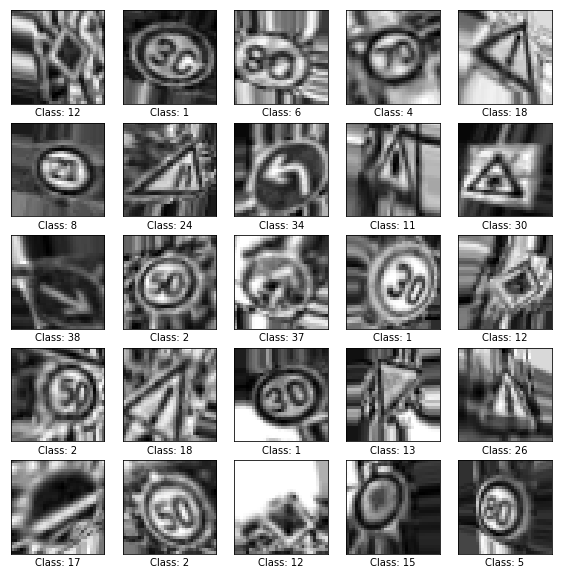

In [16]:
# Get some images from new test-set.
index = [random.randint(0, len(X_train)) for x in range(25)]

plt.figure(figsize = (10,10))
grd = gridspec.GridSpec(5,5)
grd.update(wspace=0.01, hspace=0.2) # set the spacing between axes. 

for i in range(25):
    ax = plt.subplot(grd[i])
    plt.axis('on')
    img = X_train[index[i]].squeeze()
    ax.imshow(img,cmap='gray')
    ax.set_xlabel("Class: {0}".format(np.argmax(y_train[index[i]],axis=0)))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show() 

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answers for Q1 and Q2:**
I applied the following preprocessing steps for image data:

Grayscaling and histogram equalization so the effect of brightness is removed. The color of the images is not unique of a feature. The shape of the sign and the shape of the symbol in the sign would a better unique identifier. The histogram equalizer makes the objects in the image more pronounced. Normalizing the image data brings the mean closer to 0 and make training easier.

Next, I generated additional training data by flipping some of signs (thanks Slack team for this idea) and using the image augmentation.

1. Flip all images that can be flipped. It is very simple and resourseless way to extend set of training data
2. Rotation and projection. I tried to add +20 images, but have to used only +5 more for each image because of OOM errors even on AWS. But I want to repeat my experiment when I get more powerfull PC. I used the augmentation with intensity 0.75

Last Steps:
1. I shuffled the training set to help prevent the network from overfitting to the data. 
2. I split the data into training and validation sets using sklearn's test_train_split function. I split the data so 25% of the data was validation data and 75% was training data. I have an idea that 80/20 can be better idea, but...I have done my tests and come back to it later

**Answer:**

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

def conv_layer(inp, filter_size, num_filters):
    shape = [filter_size, filter_size, inp.get_shape()[3], num_filters]
    
    W = tf.get_variable('weights', shape = shape, initializer = tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('biases', shape = [num_filters], initializer = tf.constant_initializer(0.0))
    
    x = tf.nn.conv2d(inp, W, strides=[1, 1, 1, 1], padding='SAME')
    x = tf.nn.relu(x + b)
    return x
    
def pooling(inp, size):
    pool = tf.nn.max_pool(inp,ksize = [1,size,size,1],strides = [1,size,size,1],padding = 'SAME')
    return pool
    
def fully_connected_layer(inp, num_outputs, use_relu = True):
    shape = [inp.get_shape()[1], num_outputs]
    W = tf.get_variable('weights', shape = shape, initializer = tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('biases', shape = [num_outputs],initializer = tf.constant_initializer(0.0))
    layer = tf.add(tf.matmul(inp, W), b)
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

def flatten_layer(layer, size):
    if size is not None:
        layer = pooling(layer, size)
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

In [18]:
# Let's keep all parameters in one place
model_param = {'num_classes': 43, 
               'image_size': 32, 
               'batch_size': 256, 
               'max_epochs': 80, 
               'continue': True,
               'learning_rate': 0.001,
               'l2': 0.0001, 
               'conv1': (5,32,0.9), 
               'conv2': (5,64,0.8), 
               'conv3': (5,128,0.7),
               'fcl': (1024,0.5)}

In [41]:
def model(x, param, is_training):
    
    with tf.variable_scope('conv1'):
        conv1 = conv_layer(x, filter_size = param['conv1'][0], num_filters = param['conv1'][1])
    with tf.variable_scope('pool1'):
        pool1 = pooling(conv1, 2)
        pool1 = tf.cond(is_training, lambda: tf.nn.dropout(pool1, keep_prob = param['conv1'][2]), lambda: pool1)
    
    with tf.variable_scope('conv2'):
        conv2 = conv_layer(pool1, param['conv2'][0], param['conv2'][1])
    with tf.variable_scope('pool2'):
        pool2 = pooling(conv2, 2)
        pool2 = tf.cond(is_training, lambda: tf.nn.dropout(pool2, keep_prob = param['conv2'][2]), lambda: pool2)
    
    with tf.variable_scope('conv3'):
        conv3 = conv_layer(pool2, param['conv3'][0], param['conv3'][1])
    with tf.variable_scope('pool3'):
        pool3 = pooling(conv3, 2)
        pool3 = tf.cond(is_training, lambda: tf.nn.dropout(pool3, keep_prob = param['conv3'][2]), lambda: pool3)
    
    flat_1 = flatten_layer(pool1, 4)
    flat_2 = flatten_layer(pool2, 2)
    flat_3 = flatten_layer(pool3, None)

    #flattened = tf.concat(1, [flat_1, flat_2, flat_3])
    flattened = tf.concat([flat_1, flat_2, flat_3],1)
    
    with tf.variable_scope('fcl'):
        fcl = fully_connected_layer(flattened, param['fcl'][0])
        fcl = tf.cond(is_training, lambda: tf.nn.dropout(fcl, keep_prob = param['fcl'][1]), lambda: fcl)
        
    with tf.variable_scope('out'):
        logits = fully_connected_layer(fcl, param['num_classes'], use_relu=False)
    
    return logits

In [42]:
class Paths:
    def __init__(self, params):
        self.root_path = os.getcwd() + self.get_model_name(params) + "/"
        self.var_scope = self.get_variables_scope(params)
        self.model_path = self.get_model_path()
        self.train_history_path = self.get_train_history_path()
        os.makedirs(self.root_path, exist_ok = True)

    def get_model_name(self, params):
        return "cl{}_cl{}_cl{}_fc{}".format(params['conv1'][1],params['conv2'][1],params['conv3'][1],params['fcl'])

    def get_model_path(self):
        return self.root_path + "model.ckpt"

    def get_train_history_path(self):
        return self.root_path + "train_history.npz"
    
    def get_variables_scope(self, params):
        return "k{}d{}_k{}d{}_k{}d{}_fc{}_fc0".format(params['conv1'][0], params['conv1'][1],
                                                       params['conv2'][0], params['conv2'][1],
                                                       params['conv3'][0], params['conv3'][1],
                                                       params['fcl'][0])
    
def get_time(start = None):
    if start is None:
        return time.strftime("%Y/%m/%d %H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

In [43]:
class Stop_training:
 
    def __init__(self, saver, session):
        self.saver = saver
        self.session = session
        self.best_monitored_value = np.inf
        self.best_monitored_epoch = 0
        self.restore_path = None

    def __call__(self, value, epoch):
        if (value < self.best_monitored_value):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.restore_path = self.saver.save(self.session, os.getcwd() + "/early_stopping_checkpoint")
        elif self.best_monitored_epoch + 5 < epoch:
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False

In [44]:
def curves(axis, params, train_column, valid_column):
    model_history = np.load(Paths(params).train_history_path)
    train_values = model_history[train_column]
    valid_values = model_history[valid_column]
    epochs = train_values.shape[0]
    x_axis = np.arange(epochs)
    axis.plot(x_axis[train_values > 0], train_values[train_values > 0], 'b-', linewidth=2, label="train")
    axis.plot(x_axis[valid_values > 0], valid_values[valid_values > 0], 'g-', linewidth=2, label="valid")
    return epochs

def plot_curves(params):
    curves_figure = plt.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1, 2, 1)
    epochs_plotted = curves(axis, params, train_column = "train_accuracy_history", valid_column = "valid_accuracy_history")

    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.ylim(50., 115.)
    plt.xlim(0, epochs_plotted)

    axis = curves_figure.add_subplot(1, 2, 2)
    epochs_plotted = curves(axis, params, train_column = "train_loss_history", valid_column = "valid_loss_history")

    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(0.0001, 10.)
    plt.xlim(0, epochs_plotted)
    plt.yscale("log")

In [47]:
def optimize(params, X_train, y_train, X_valid, y_valid, X_test, y_test):
    start = time.time()
    paths = Paths(params)
    graph = tf.Graph()
    
    with graph.as_default():
        x_batch = tf.placeholder(tf.float32, shape = (None, params['image_size'], params['image_size'], 1))
        y_batch = tf.placeholder(tf.float32, shape = (None, params['num_classes']))
        is_training = tf.placeholder(tf.bool)
        #current_epoch = tf.Variable(0, trainable=False)  
            
        with tf.variable_scope(paths.var_scope):
            logits = model(x_batch, params, is_training)
            with tf.variable_scope('fcl', reuse = True):
                l2_loss = tf.nn.l2_loss(tf.get_variable('weights'))

        predictions = tf.nn.softmax(logits)
        #softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y_batch)
        softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_batch)
        
        
        cost = tf.reduce_mean(softmax_cross_entropy) + params['l2'] * l2_loss  

        optimizer = tf.train.AdamOptimizer(learning_rate = params['learning_rate']).minimize(cost)

    with tf.Session(graph = graph) as session:
        if params['max_epochs'] > 0:
            print("================= START TRAINING ==================")
        else:
            print("================= START TESTING  ==================")       
        print(" Timestamp: " + get_time())
        
        session.run(tf.global_variables_initializer())
        
        def evaluate(X, y):
            p = []
            sce = []
            num_examples = len(X)
            bs = params['batch_size']
            for offset in range(0, num_examples, bs):
                x_b, y_b = X[offset:offset+bs], y[offset:offset+bs]
                [p_batch, sce_batch] = session.run([predictions, softmax_cross_entropy], 
                                                feed_dict = {x_batch: x_b, y_batch: y_b, is_training:False})
                p.extend(p_batch)
                sce.extend(sce_batch)
            p = np.array(p)
            sce = np.array(sce)
            accuracy = 100.0 * np.sum(np.argmax(p, 1) == np.argmax(y, 1)) / p.shape[0]
            loss = np.mean(sce)
            return (accuracy, loss)
        
        if params['continue']: 
            try:
                tf.train.Saver().restore(session, paths.model_path)
                print("Session restored")
            except Exception as e:
                print("Failed restoring previously trained model.")
                pass
            
        saver = tf.train.Saver()
        early_stopping = Stop_training(tf.train.Saver(), session)
        
        train_loss_history = np.empty([0], dtype = np.float32)
        train_accuracy_history = np.empty([0], dtype = np.float32)
        
        valid_loss_history = np.empty([0], dtype = np.float32)
        valid_accuracy_history = np.empty([0], dtype = np.float32)
         
        for epoch in range(params['max_epochs']):
            print("EPOCH", epoch)
                        
            bs = params['batch_size']
            num_examples = len(X_train)
            for offset in range(0, num_examples, bs):
                end = offset + bs
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                session.run([optimizer], feed_dict = {x_batch : batch_x, y_batch : batch_y, is_training : True})
                print_progress(offset, num_examples)
            
            if (epoch % 5 == 0):
                train_accuracy, train_loss = evaluate(X_train, y_train)
                valid_accuracy, valid_loss = evaluate(X_valid, y_valid)

                print("\n-------------- EPOCH %4d/%d --------------" % (epoch, params['max_epochs']))
                print("     Train loss: %.8f, accuracy: %.2f%%" % (train_loss, train_accuracy))
                print("Validation loss: %.8f, accuracy: %.2f%%" % (valid_loss, valid_accuracy))
                print("      Best loss: %.8f at epoch %d" % (early_stopping.best_monitored_value, early_stopping.best_monitored_epoch))
                print("   Elapsed time: " + get_time(start))
                print("      Timestamp: " + get_time())
                    
            else:
                valid_loss = 0.
                valid_accuracy = 0.
                train_loss = 0.
                train_accuracy = 0.
                
            valid_loss_history = np.append(valid_loss_history, [valid_loss])
            valid_accuracy_history = np.append(valid_accuracy_history, [valid_accuracy])
            train_loss_history = np.append(train_loss_history, [train_loss])
            train_accuracy_history = np.append(train_accuracy_history, [train_accuracy])
            
            if valid_loss == 0:
                _, valid_loss = evaluate(X_valid, y_valid)

            if early_stopping(valid_loss, epoch):
                print("Early stopping.\nBest monitored loss was {:.8f} at epoch {}."
                    .format(early_stopping.best_monitored_value, early_stopping.best_monitored_epoch))
                break

        test_accuracy, test_loss = evaluate(X_test, y_test)
        valid_accuracy, valid_loss = evaluate(X_valid, y_valid)

        print("=============================================")
        print(" Valid loss: %.8f, accuracy = %.2f%%)" % (valid_loss, valid_accuracy)) 
        print(" Test loss: %.8f, accuracy = %.2f%%)" % (test_loss, test_accuracy)) 
        print(" Total time: " + get_time(start))
        print("  Timestamp: " + get_time())

        # Save model weights for future use.
        saved_model_path = saver.save(session, paths.model_path)
        print("Model file: " + saved_model_path)
        np.savez(paths.train_history_path, train_loss_history = train_loss_history, train_accuracy_history = train_accuracy_history, valid_loss_history = valid_loss_history, valid_accuracy_history = valid_accuracy_history)
        print("Train history file: " + paths.train_history_path)
        print("Finished training with %.2f%% accuracy on the testing set (loss = %.6f*)." % (test_accuracy, test_loss))
        
        plot_curves(params)
        plt.show()
    session.close()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I tested multiple models but decided to stop on very simple (because I have to test is as much fast as I can) but very effective model I found exploring LeCun's paper and some articles in Internet
<img src="model.png">

================= START TRAINING ==================
 Timestamp: 2017/05/14 11:15:12
INFO:tensorflow:Restoring parameters from c:\mlpy\Udacity\Level1\CarND-Traffic-Signscl32_cl64_cl128_fc(1024, 0.5)/model.ckpt
Failed restoring previously trained model.
EPOCH 0
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
-------------- EPOCH    0/80 --------------
     Train loss: 0.34948727, accuracy: 89.82%
Validation loss: 0.36504567, accuracy: 89.07%
      Best loss: inf at epoch 0
   Elapsed time: 00:01:36
      Timestamp: 2017/05/14 11:16:46
EPOCH 1
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%EPOCH 2
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%EPOCH 3
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%EPOCH 4
 |██████████████████████████████████████████

Early stopping.
Best monitored loss was 0.02558906 at epoch 40.
 Valid loss: 0.02558906, accuracy = 99.19%)
 Test loss: 0.13670075, accuracy = 96.84%)
 Total time: 00:19:31
  Timestamp: 2017/05/14 11:34:42
Model file: c:\mlpy\Udacity\Level1\CarND-Traffic-Signscl32_cl64_cl128_fc(1024, 0.5)/model.ckpt
Train history file: c:\mlpy\Udacity\Level1\CarND-Traffic-Signscl32_cl64_cl128_fc(1024, 0.5)/train_history.npz
Finished training with 96.84% accuracy on the testing set (loss = 0.136701*).


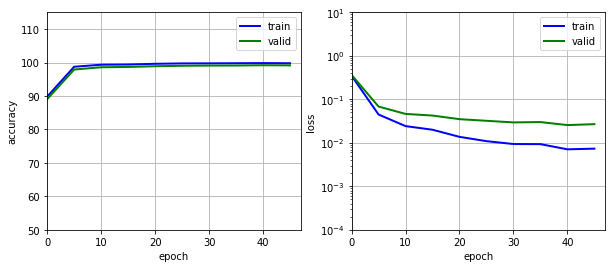

In [48]:
### Train your model here.
### Feel free to use as many code cells as needed.

optimize(model_param, X_train, y_train, X_valid, y_valid, X_test, y_test)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I stoped on: <p>
Batch size = 256<p>
Epoch = 80 (but it's beter to use more)<p>
Optimizer = AdamOptimizer<p>
Learning_rate = 0.001<p>
L2 Regularization = 0.0001<p>
Layers:<p>
 Conv. #1 = (5,32,0.5) where (Type, Size, Dropout)<p>
 Conv. #2 = (5,64,0.5) <p>
 Conv. #3 = (5,128,0.5)<p>
 FC = (1024,0.5)<p>
Augmentation intensity = 0.75<p>

I experimented with different batch sizes, Learning rates and number of epochs. Increasing of learning rates, requiered more epochs. Changing the bach size to 128 increases time of training from 3 to 7 min per epoch. So I desided to keep this parameters to finish the training during 3-4 hours. I think LR 0.0001 with 128 batch size can potentially give better result but the training time will increase also.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I researched different types of models developed by researchers and different parameters. I found 3 models that gave similar results (all of them are variance of LeCun network) and after couple of days of experiments I found parameters that give the best result using less time resourses.
My first network was from our Lessosns but I got very poor results.

Second was: Conv(5x5x1) -> Conv/ReLu(5x5x32)-> Conv/ReLu(5x5x32)+Drop(0.5)-> Conv/ReLu(5x5x64)-> Conv/ReLu(5x5x64)+Drop(0.5)-> Conv/ReLu(5x5x128)-> Conv/ReLu(5x5x128)+Drop(0.5) ->Flatted with all ConvLayers ->FC(1024)->Drop(0.5)->FC(1024)-Softmax

So it gave better result but looks very complicated and strange (LeCun version was....more logical). So I decided to start from image preprocessing and set extension. I removed color (color is not very important for signs), and extended set.
After that I started the model optimizing: Conv(5x5x1) was removed first because we have 1 channel for image. Next step I removed double layers. It increased the training spead and didn't change the results. Last step I changed drop - made it not so dramatical :-) 
All this steps increase accuracy on validation up to 99% and on training I got 96%. My target is 98.8%
I'm going to get it:
- increase training set. It is the most difficult part. Augmentation just changed old images so I think I need to find more fresh signs
- increase learning rate to 0.0001
- change batch and number of epoch

I decided don't change regularization and left from our lessons.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [52]:
def get_top_k(params, X):
    paths = Paths(params)
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x = tf.placeholder(tf.float32, shape = (None, params['image_size'], params['image_size'], 1))
        is_training = tf.constant(False)
        with tf.variable_scope(paths.var_scope):
            predictions = tf.nn.softmax(model(tf_x, params, is_training))
            top_k_predictions = tf.nn.top_k(predictions, 5)
    
    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())
        tf.train.Saver().restore(session, paths.model_path)
        bs = params['batch_size']
        num_examples = len(X)
        for offset in range(0, num_examples, bs):
            end = offset + bs
            batch_x = X[offset:end]
            [p] = session.run([top_k_predictions], feed_dict = {tf_x : batch_x } )
            #print_progress(offset, num_examples)
    print(top_k_predictions)    
    return np.array(p), top_k_predictions

def plot_image_statistics(predictions, index):
    # Prepare original and preprocessed images
    original = io.imread(os.getcwd() + '/test/' + "{0:0>2}".format(index + 1) + '.png')
    preprocessed = X_custom[index].reshape(32, 32)
        
    plt.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    plt.imshow(original)
    plt.axis('off')

    plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    plt.imshow(preprocessed, cmap='gray')
    plt.axis('off')

    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, predictions[0][index], align='center')
    plt.yticks(np.arange(5)+.5, sign_names[predictions[1][index].astype(int)])
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    plt.show()

(32, 32, 3)
(23, 32, 32, 3)
39


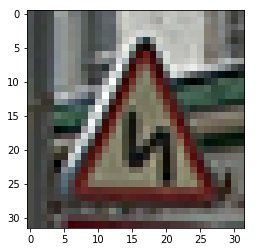

In [46]:
# Load images from .png files to `X_custom` NumPy array
X_custom = np.empty([0, 32, 32, 3], dtype = np.uint8)
for i in range(23):
    image = io.imread(os.getcwd() + '/test/' + "{0:0>2}".format(i + 1) + '.png')
    image = image.astype(np.uint8)
    X_custom = np.append(X_custom, [image[:, :, :3]], axis = 0)

print(X_custom[0].shape)
print(X_custom.shape)    
# Provide labels of the captured images:
y_custom = np.array([21, 39, 17, 17, 17, 39, 39, 40, 40, 34, 28, 39, 28, 17, 38, 13, 40, 13, 38, 38, 11, 40, 28])
print(y_custom[1]) 
plt.imshow(X_custom[0]);


In [47]:
print(X_custom.shape[0])
# Preprocess and get predictions based on the current model
X_custom, y_custom = grayscaling(X_custom, y_custom)

23
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


In [48]:
print(X_custom.shape)

(23, 32, 32, 1)


In [55]:

model_param = {'num_classes': 43, 
               'image_size': 32, 
               'batch_size': 256, 
               'max_epochs': 40, 
               'continue': True,
               'learning_rate': 0.001,
               'l2': 0.0001, 
               'conv1': (5,32,0.5), 
               'conv2': (5,64,0.5), 
               'conv3': (5,128,0.5),
               'fcl': (1024,0.5)}

pred_base, pred_top = get_top_k(model_param, X_custom)

TopKV2(values=<tf.Tensor 'k5d32_k5d64_k5d128_fc1024_fc0/TopKV2:0' shape=(?, 5) dtype=float32>, indices=<tf.Tensor 'k5d32_k5d64_k5d128_fc1024_fc0/TopKV2:1' shape=(?, 5) dtype=int32>)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Actual class:  Double curve


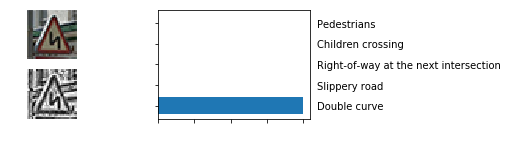

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


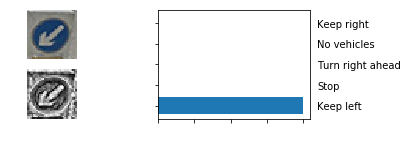

---------------------------------------------------------------------------------------------------

Actual class:  No entry


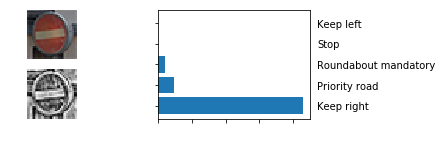

---------------------------------------------------------------------------------------------------

Actual class:  No entry


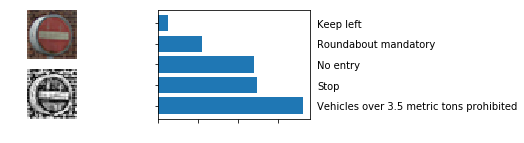

---------------------------------------------------------------------------------------------------

Actual class:  No entry


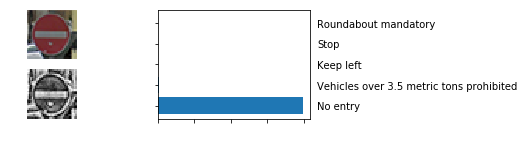

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


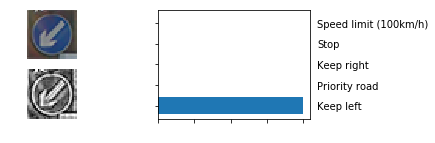

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


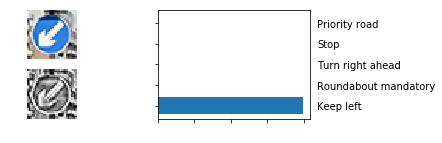

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


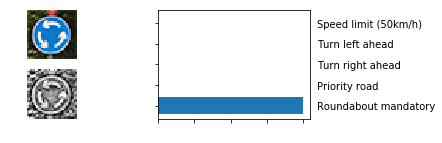

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


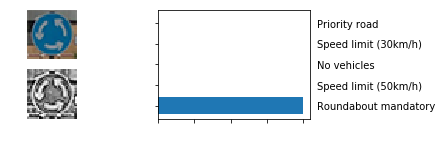

---------------------------------------------------------------------------------------------------

Actual class:  Turn left ahead


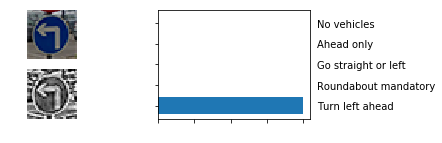

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


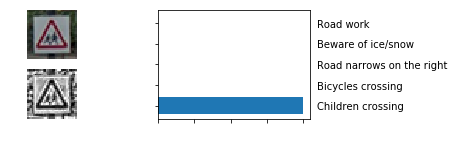

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


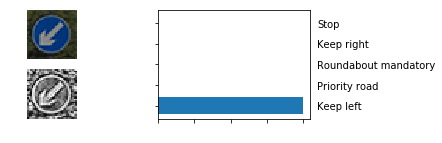

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


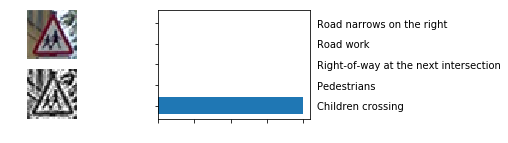

---------------------------------------------------------------------------------------------------

Actual class:  No entry


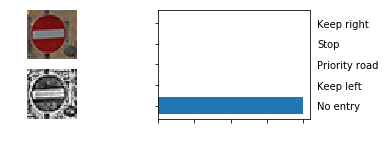

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


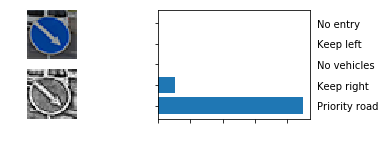

---------------------------------------------------------------------------------------------------

Actual class:  Yield


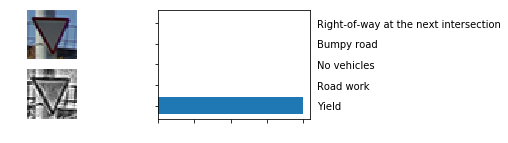

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


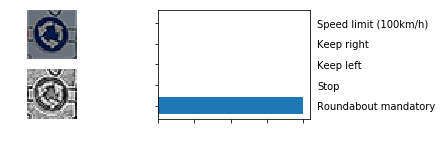

---------------------------------------------------------------------------------------------------

Actual class:  Yield


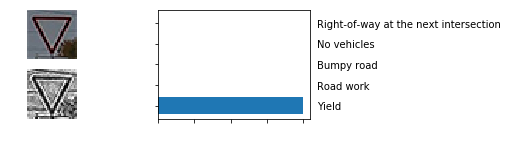

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


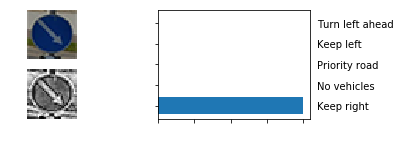

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


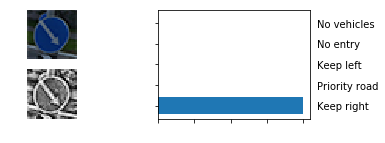

---------------------------------------------------------------------------------------------------

Actual class:  Right-of-way at the next intersection


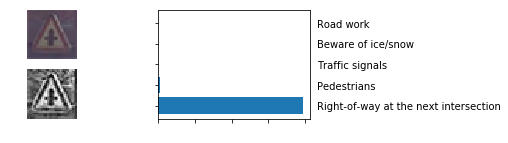

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


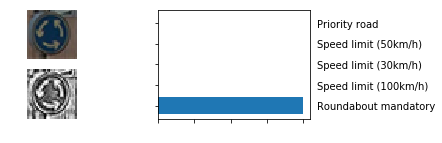

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


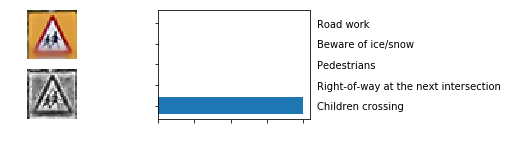

---------------------------------------------------------------------------------------------------



In [53]:
sign_file = pd.read_csv("signnames.csv")
sign_names = sign_file.values[:, 1]
# For every example plot original image, preprocessed image, and model predictions.
for i in range(23):
    print("Actual class: ", sign_names[y_custom[i]])
    plot_image_statistics(pred_base, i)
    print("---------------------------------------------------------------------------------------------------\n")

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
I got 3 out of 23 signs correctly, it's 13%. I think this value can be better if add more images in the training set

The winner of loosers is "No entry" sign. If we check all "No Entry" signs, it is very easy to see that "correct" signs have more homogeneous background. So white line is more visible and contrast. It's confused. But in "real" situation it can be solved I think. Camera can make more then one img of the sign so it helps to improve the quality. 


In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

**Answer:**
Pls see my answer on Question #6. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.